# Basic Logistic Regression in Pytorch

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch


## Import data

In [2]:
from torchvision import datasets, transforms

# Don't need to do type hints in prod
mnist_train: torch.utils.data.Dataset = datasets.MNIST(root="./datasets", 
                                                       train=True, 
                                                       transform=transforms.ToTensor(), 
                                                       download=True)

mnist_test: torch.utils.data.Dataset = datasets.MNIST(root="./datasets", 
                                                      train=False, 
                                                      transform=transforms.ToTensor(), 
                                                      download=True)

print(f"No. of MNIST training examples: {len(mnist_train)}")
print(f"No. of MNIST test examples: {len(mnist_test)}")

No. of MNIST training examples: 60000
No. of MNIST test examples: 10000


## Plotting and manipulating the data

Image shape: torch.Size([1, 28, 28]) This means that there is 1 channel, with 28x28 pixels
Reshaped image: torch.Size([28, 28])
Label: 1


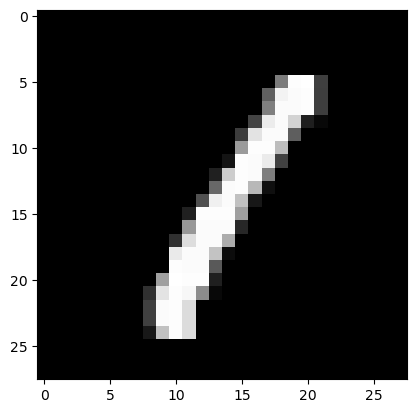

In [5]:
# Pick an arbitrary item from the training dataset
image, label = mnist_train[3]

# Plot the imagine
print(f"Image shape: {image.shape}", "This means that there is 1 channel, with 28x28 pixels")

image = image.reshape((28, 28))
print(f"Reshaped image: {image.shape}")

print(f"Label: {label}")

plt.imshow(image, cmap="gray")
plt.show()

## Using the dataloader

Images shape: torch.Size([100, 1, 28, 28])
Labels shape: torch.Size([100])
Image type: <class 'torch.Tensor'>
Label type: <class 'torch.Tensor'>


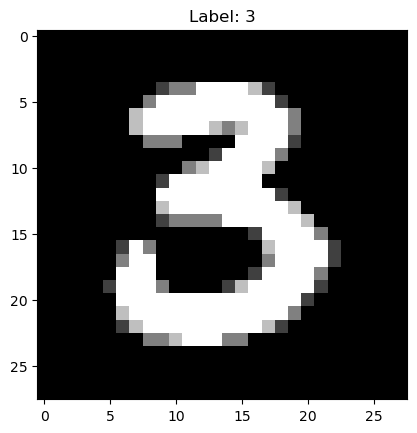

In [ ]:
train_loader = torch.utils.data.DataLoader(mnist_train, 
                                           batch_size=100, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, 
                                          batch_size=100, 
                                          shuffle=False)
# print(type(train_loader))

# Get the first batch from the DataLoader
images, labels = next(iter(train_loader))

# Print shape and types
print(f"Images shape: {images.shape}")  # (batch_size, channels, height, width)
print(f"Labels shape: {labels.shape}")  # (batch_size,)
print(f"Image type: {type(images)}")    # torch.Tensor
print(f"Label type: {type(labels)}")    # torch.Tensor

plt.imshow(images[0].squeeze(), cmap="gray")  # Remove channel dim for visualization
plt.title(f"Label: {labels[0].item()}")
plt.show()